<a href="https://colab.research.google.com/github/iotanalytics/IoTTutorial/blob/main/code/detection_and_segmentation/Event_detection_and_segmentation_based_on_Standard_Deviation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install influxdb

     |████████████████████████████████| 77 kB 3.3 MB/s 


# Event detection and segmentation based on Standard Deviation

In [ ]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pywt
import influxdb
from influxdb import InfluxDBClient
import operator
import scipy.signal as sg
import scipy as sp
import pandas as pd
dat = pd.read_csv('case1.csv').to_numpy()
data=dat[81,:]

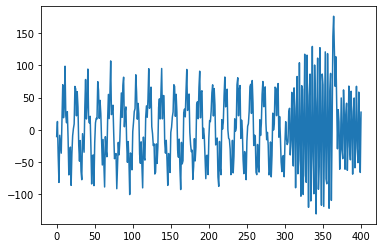

In [ ]:
fig, ax = plt.subplots()
plt.plot(data)
plt.show()

maximum level is 5


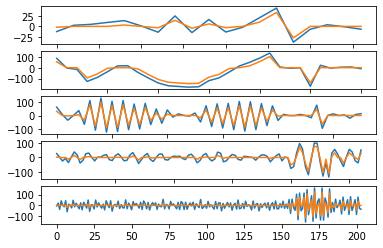

In [ ]:
def wdenoise(data, method, threshold):
    # Create wavelet object and define parameters
    w = pywt.Wavelet(method)
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    # maxlev = 2 # Override if desired
    print("maximum level is " + str(maxlev))
    # Decompose into wavelet components, to the level selected:
    coeffs = pywt.wavedec(data, method, level=maxlev)  
    #cA = 0.0
    #cA = pywt.threshold(cA, threshold*max(cA))
    # plt.figure()
    for i in range(1, len(coeffs)):
        plt.subplot(maxlev, 1, i)
        plt.plot(coeffs[i])
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        plt.plot(coeffs[i])
    datarec = pywt.waverec(coeffs, method)
    return datarec


# denoising with wavelet
#datarec = wdenoise(data, 'db8', 0.04) # 
datarec = wdenoise(data, 'sym4', 0.24) # 
# foot step separation
mintime = 0
maxtime = mintime + len(data) + 1
ind = len(data)

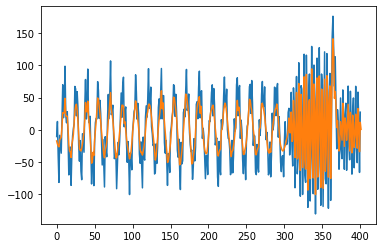

In [ ]:
fig, ax = plt.subplots()
plt.plot(data)
plt.plot(datarec)
plt.show()

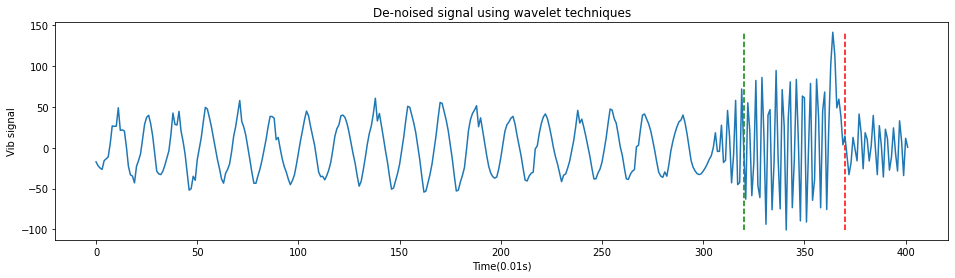

In [ ]:
## window size
window_size = 10
FLAG = False
threshold_of_std = 45
data_std_list = []
green_line = []
red_line = []
## run over the data
for i in range(0,len(datarec)-window_size,window_size):
    # print(datarec[i:i+window_size])
    window_data_std = np.std(np.asarray(datarec[i:i+window_size]))
    data_std_list.append(window_data_std)
    # exit()

    if FLAG == False:
        if window_data_std > threshold_of_std:
            FLAG = True
            green_line.append(i)
        else:
            pass

    else:
        if window_data_std <= threshold_of_std:
            FLAG = False
            red_line.append(i)

# print(max(see))
y_min = min(datarec)
y_max = max(datarec)

plt.figure(figsize=(16, 4))
plt.xlabel('Time(0.01s)')
plt.ylabel('Vib signal')
plt.title("De-noised signal using wavelet techniques")
plt.plot(datarec) # [mintime:maxtime-1])
plt.vlines(green_line, y_min, y_max, 'g', '--', label='example')
plt.vlines(red_line, y_min, y_max, 'r', '--', label='example')
plt.show()


# One-class SVM
The method of Support Vector Data Description by Tax and Duin (SVDD) takes a spherical, instead of planar, approach. The algorithm obtains a spherical boundary, in feature space, around the data. The volume of this hypersphere is minimized, to minimize the effect of incorporating outliers in the solution.
It basically separates all the data points from the origin (in feature space $\mathcal{F}$) and maximizes the distance from this hyperplane to the origin. This results in a binary function which captures regions in the input space where the probability density of the data lives. Thus the function returns +1 in a “small” region (capturing the training data points) and −1 elsewhere.

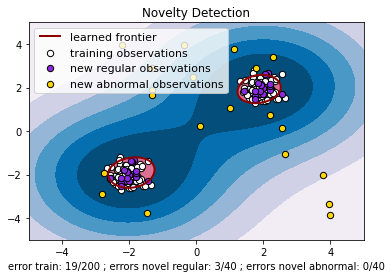

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

# Support Vector Data Description (SVDD)

Tax D M J, Duin R P W. Support vector data description. Machine learning, 2004, 54(1): 45-66.


https://github.com/iqiukp/SVDD
Python Code for abnormal detection or fault detection using SVDD.

Main features
SVDD model for training dataset containing only positive training data. (SVDD)
SVDD model for training dataset containing both positive training data and negative training data. (nSVDD)
Multiple kinds of kernel functions.
Visualization module including ROC curve plotting, test result plotting, and decision boundary.



*** SVDD model training finished ***

iter             = 8
time cost        = 0.0362 s
obj              = -0.3568
pData            = 77.7778 %
nData            = 22.2222 %
nSVs             = 3
radio of nSVs    = 6.6667 %
accuracy         = 91.1111 %




*** SVDD model test finished ***

time cost        = 0.0051 s
accuracy         = 99.0476 %




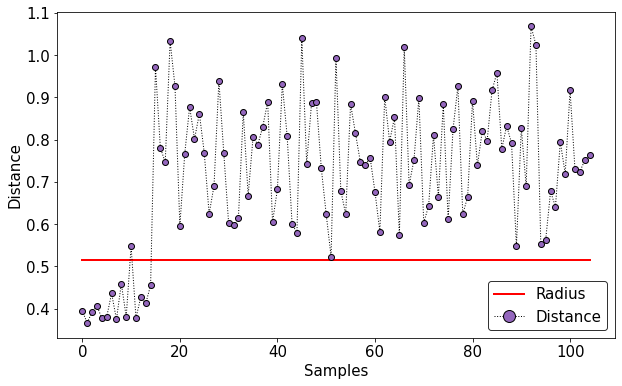

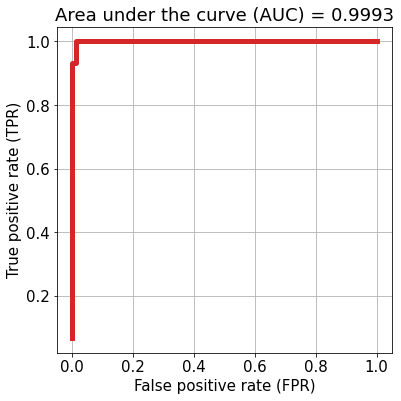

In [ ]:
# -*- coding: utf-8 -*-

import sys
sys.path.append("..")
from svdd import SVDD
from visualize import Visualization as draw
from data import PrepareData as load

# load banana-shape data
trainData, testData, trainLabel, testLabel = load.iris()

# set SVDD parameters
parameters = {"positive penalty": 0.9,
              "negative penalty": 0.8,
              "kernel": {"type": 'gauss', "width": 1/24},
              "option": {"display": 'on'}}


# construct an SVDD model
svdd = SVDD(parameters)

# train SVDD model
svdd.train(trainData, trainLabel)


# test SVDD model
distance, accuracy = svdd.test(testData, testLabel)

# visualize the results
draw.testResult(svdd, distance)
draw.testROC(testLabel, distance)